In [ ]:
!pip install mne

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#read all file
all_files_path=glob('drive/MyDrive/edf_files/*.edf')
print(len(all_files_path))

28


In [ ]:
healthy_file_path=[i for i in all_files_path if  'h' in i.split('/')[3]]
patient_file_path=[i for i in all_files_path if  's' in i.split('/')[3]]

print(f"Healthy: {len(healthy_file_path)}, Patients: {len(patient_file_path)}")

Healthy: 14, Patients: 14


In [ ]:
# ----------- READ & PREPROCESS SINGLE SUBJECT ----------- #
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

    # Crop first/last noisy parts if needed (here we keep full, thesis cropped 60–120s for demo)
    # raw.crop(tmin=60, tmax=120)

    # Keep EEG only
    raw.pick_types(eeg=True)

    # Average reference
    raw.set_eeg_reference('average', projection=False)

    # Remove line noise
    raw.notch_filter(freqs=[50, 100], verbose=False)

    # Bandpass filter (0.5–50 Hz for final analysis)
    raw.filter(l_freq=0.5, h_freq=50, verbose=False)

    # ---------- ICA (Thesis style) ----------
    filt_raw = raw.copy()
    # Only high-pass at 0.5 Hz, no low-pass because Nyquist = 125
    filt_raw.load_data().filter(l_freq=0.5, h_freq=None, verbose=False)

    ica = mne.preprocessing.ICA(n_components=15, max_iter='auto', random_state=97, method="fastica")
    ica.fit(filt_raw)

    # Identify and exclude EOG/artifact components
    eog_inds, _ = ica.find_bads_eog(raw, ch_name=['Fp1','Fp2'])
    ica.exclude = eog_inds

    # Apply ICA
    raw = ica.apply(raw)

    # ---------- Epoch into non-overlapping 5s ----------
    epochs = mne.make_fixed_length_epochs(raw, duration=5, overlap=1, preload=True)
    return epochs.get_data()   # shape = (trials, channels, samples)

In [ ]:
# Read all subjects
control_epochs_array  = [read_data(f) for f in healthy_file_path]
patients_epochs_array = [read_data(f) for f in patient_file_path]

In [ ]:
# Labels (0 = healthy, 1 = schizophrenia)
control_epochs_labels  = [np.zeros(len(ep)) for ep in control_epochs_array]
patients_epochs_labels = [np.ones(len(ep)) for ep in patients_epochs_array]

In [ ]:
# Merge
data_list   = control_epochs_array + patients_epochs_array
label_list  = control_epochs_labels + patients_epochs_labels
groups_list = [[i] * len(ep) for i, ep in enumerate(data_list)]  # group per subject

In [ ]:
# Convert to arrays
data_array  = np.vstack(data_list)     # (trials, channels, samples)
label_array = np.hstack(label_list)    # (trials,)
group_array = np.hstack(groups_list)   # (trials,)

In [ ]:
# Match your earlier format: move channels last
data_array = np.moveaxis(data_array, 1, 2)  # (trials, samples, channels)


In [ ]:
print("Final shapes:")
print("X:", data_array.shape, "y:", label_array.shape, "groups:", group_array.shape)


Final shapes:
X: (7201, 1250, 19) y: (7201,) groups: (7201,)


In [ ]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==================================================================
# STEP 1: Improved Model Architecture
# ==================================================================
def create_model(input_shape=(1250, 19)):
    model = Sequential([
        Conv1D(32, 15, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPool1D(4),
        Dropout(0.3),

        Conv1D(64, 7, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool1D(4),
        Dropout(0.4),

        Conv1D(128, 5, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAvgPool1D(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model=create_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1250, 32)       │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1250, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 312, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 312, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 312, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 78, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 78, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 78, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 78, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,665 (256.50 KB)

 Trainable params: 65,217 (254.75 KB)

 Non-trainable params: 448 (1.75 KB)


📊 Comparing Performance Metrics Across Different Folds...

Running 5-fold cross-validation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Finished 5-fold CV. Mean Accuracy: 0.7854 | Precision: 0.7704 | Recall: 0.8757 | F1-Score: 0.8197

Running 10-fold cross-validation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Finished 10-fold CV. Mean Accuracy: 0.8808 | Precision: 0.8883 | Recall: 0.8957 | F1-Score: 0.8920


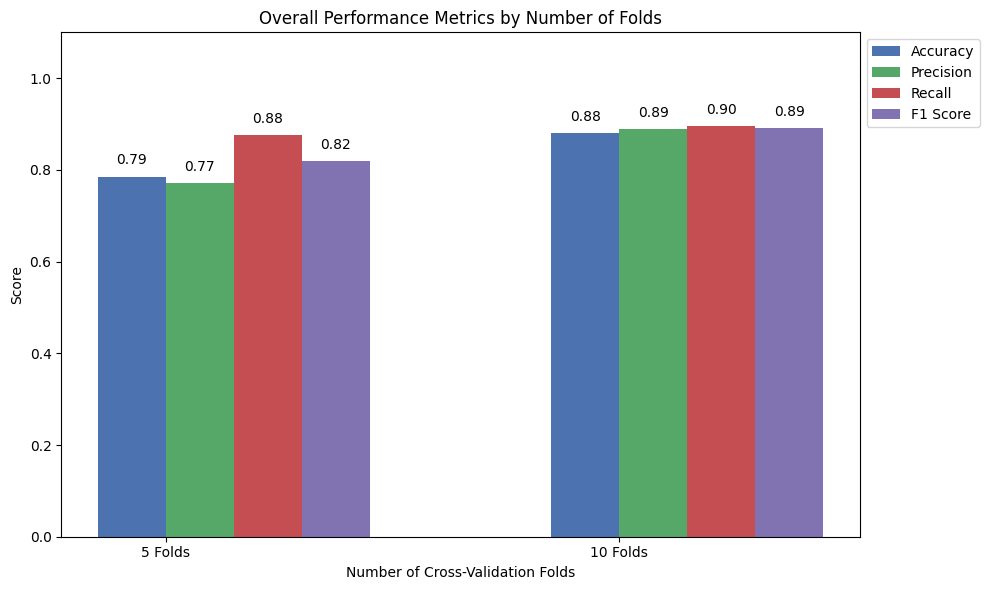


✨ Bar graph for fold comparison is complete!


In [ ]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

transformer_accuracies = []
all_true = []
all_pred = []
debug_distributions = {}

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# --- New Snippet for N_Splits Comparison ---

print("\n📊 Comparing Performance Metrics Across Different Folds...")
fold_configs = [5, 10]
fold_results = {folds: {'precision': [], 'recall': [], 'f1_score': [], 'accuracy': []} for folds in fold_configs}

for num_folds in fold_configs:
    print(f"\nRunning {num_folds}-fold cross-validation...")
    all_true_folds = []
    all_pred_folds = []
    fold_accuracies = []

    # Initialize a new GroupKFold for each configuration
    gkf_comparison = GroupKFold(n_splits=num_folds)

    for fold, (train_idx, val_idx) in enumerate(gkf_comparison.split(data_array, label_array, group_array)):
        x_train, y_train = data_array[train_idx], label_array[train_idx]
        x_val, y_val = data_array[val_idx], label_array[val_idx]

        # Re-scale data for each new run
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
        x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

        model = create_model(input_shape=(1250, 19))
        model.fit(x_train, y_train, epochs=10, batch_size=128,
                  validation_data=(x_val, y_val), verbose=0, callbacks=[early_stop])

        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        fold_accuracies.append(val_acc)

        y_val_pred_probs = model.predict(x_val)
        y_val_preds = (y_val_pred_probs > 0.5).astype(int).flatten()
        y_val_true = y_val.flatten()

        all_pred_folds.extend(y_val_preds)
        all_true_folds.extend(y_val_true)

    # Calculate overall metrics for the current fold setting
    precision_overall = precision_score(all_true_folds, all_pred_folds, zero_division=0)
    recall_overall = recall_score(all_true_folds, all_pred_folds, zero_division=0)
    f1_overall = f1_score(all_true_folds, all_pred_folds, zero_division=0)
    mean_accuracy = np.mean(fold_accuracies)

    fold_results[num_folds]['precision'] = precision_overall
    fold_results[num_folds]['recall'] = recall_overall
    fold_results[num_folds]['f1_score'] = f1_overall
    fold_results[num_folds]['accuracy'] = mean_accuracy

    print(f"Finished {num_folds}-fold CV. Mean Accuracy: {mean_accuracy:.4f} | Precision: {precision_overall:.4f} | Recall: {recall_overall:.4f} | F1-Score: {f1_overall:.4f}")

# Plotting the new bar graph for folds comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']
x_labels = [f'{folds} Folds' for folds in fold_configs]
x = np.arange(len(x_labels))

width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = [fold_results[folds][metric] for folds in fold_configs]
    ax.bar(x + i * width - 1.5 * width, values, width, label=metric.replace('_', ' ').title(), color=colors[i])

ax.set_ylabel('Score')
ax.set_xlabel('Number of Cross-Validation Folds')
ax.set_title('Overall Performance Metrics by Number of Folds')
ax.set_xticks(x - width)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add value labels on top of the bars
for i, metric in enumerate(metrics_to_plot):
    for j, folds in enumerate(fold_configs):
        val = fold_results[folds][metric]
        ax.text(x[j] + i * width - 1.5 * width, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✨ Bar graph for fold comparison is complete!")


📂 Fold 1
Validation class distribution: Counter({np.float64(0.0): 458, np.float64(1.0): 339})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
✅ Fold 1 Accuracy: 0.6186 | Precision: 0.5272 | Recall: 1.0000

📂 Fold 2
Validation class distribution: Counter({np.float64(0.0): 472, np.float64(1.0): 271})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
✅ Fold 2 Accuracy: 0.9879 | Precision: 0.9712 | Recall: 0.9963

📂 Fold 3
Validation class distribution: Counter({np.float64(1.0): 518, np.float64(0.0): 224})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
✅ Fold 3 Accuracy: 0.7844 | Precision: 0.7720 | Recall: 0.9807

📂 Fold 4
Validation class distribution: Counter({np.float64(0.0): 455, np.float64(1.0): 286})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
✅ Fold 4 Accuracy: 0.8556 | Precision: 0.7507 | Recall: 0.9371

📂 Fold 5
Validation class distribution: Counter({np.float64(0.0): 721})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
✅ Fold 5 Accuracy: 0.9723 | Precision: 0.0000 | Recall: 0.0000

📂 Fold 6
Validation class distribution: Counter({np.float64(1.0): 563, np.float64(0.0): 236})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
✅ Fold 6 Accuracy: 0.9574 | Precision: 0.9981 | Recall: 0.9414

📂 Fold 7
Validation class distribution: Counter({np.float64(1.0): 1055})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
✅ Fold 7 Accuracy: 0.9725 | Precision: 1.0000 | Recall: 0.9725

📂 Fold 8
Validation class distribution: Counter({np.float64(1.0): 523, np.float64(0.0): 231})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
✅ Fold 8 Accuracy: 0.8966 | Precision: 0.8752 | Recall: 0.9924

📂 Fold 9
Validation class distribution: Counter({np.float64(0.0): 227, np.float64(1.0): 211})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
✅ Fold 9 Accuracy: 0.9589 | Precision: 0.9949 | Recall: 0.9194

📂 Fold 10
Validation class distribution: Counter({np.float64(0.0): 227, np.float64(1.0): 184})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
✅ Fold 10 Accuracy: 0.8564 | Precision: 0.9139 | Recall: 0.7500

🧾 Prediction Distributions for All Folds:
Fold 1: Predicted {np.int64(1): 643, np.int64(0): 154}, True {np.float64(0.0): 458, np.float64(1.0): 339}
Fold 2: Predicted {np.int64(0): 465, np.int64(1): 278}, True {np.float64(0.0): 472, np.float64(1.0): 271}
Fold 3: Predicted {np.int64(1): 658, np.int64(0): 84}, True {np.float64(0.0): 224, np.float64(1.0): 518}
Fold 4: Predicted {np.int64(0): 384, np.int64(1): 357}, True {np.float64(0.0): 455, np.float64(1.0): 286}
Fold 5: Predicted {np.int64(0): 701, np.int64(1): 20}, True {np.float64(0.0): 721}
Fold 6: Predicted {np.int64(0): 268, np.int64(1): 531}, True {np.float64(0.0): 236, np.float64(1.0): 563}
Fold 7: Predicted {np.int64(1): 1026, np.int64(0): 29}, True {np.float64(1.0): 1055}
Fold 8: Predicted {np.int64(1): 593, np.int64(0): 161}, True {np.float64(0.0): 231, np.float64(1.0): 523}
Fold 9: Predicted {np.int64(0): 243, np.int64(1): 

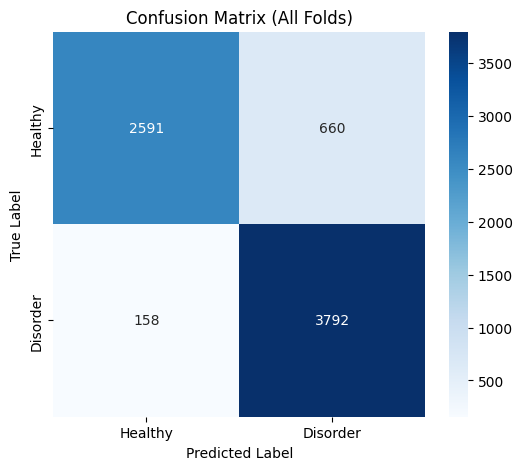

In [ ]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

transformer_accuracies = []
all_true = []
all_pred = []
debug_distributions = {}

gkf = GroupKFold(n_splits=10, shuffle=True, random_state=42)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

for fold, (train_idx, val_idx) in enumerate(gkf.split(data_array, label_array, group_array)):
    print(f"\n📂 Fold {fold+1}")
    y_val = label_array[val_idx]
    print("Validation class distribution:", Counter(y_val))


    x_train, y_train = data_array[train_idx], label_array[train_idx]
    x_val, y_val = data_array[val_idx], label_array[val_idx]

    # Feature scaling (standardize across channels)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

    # Build & train transformer model
    model = create_model()
    model.fit(x_train, y_train, epochs=100, batch_size=128,
              validation_data=(x_val, y_val), verbose=0, callbacks=[early_stop])

    # Evaluate accuracy
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    transformer_accuracies.append(val_acc)

    # Predict and store for confusion matrix
    y_val_pred_probs = model.predict(x_val)
    y_val_preds = (y_val_pred_probs > 0.5).astype(int).flatten()
    y_val_true = y_val.flatten()

    all_pred.extend(y_val_preds)
    all_true.extend(y_val_true)

    # Saving Distributions Information
    debug_distributions[fold] = {
        'predicted': dict(Counter(y_val_preds)),
        'true': dict(Counter(y_val_true))
    }

    # Precision & Recall for current fold
    precision = precision_score(y_val_true, y_val_preds, zero_division = 0)
    recall = recall_score(y_val_true, y_val_preds, zero_division=0)

    print(f"✅ Fold {fold+1} Accuracy: {val_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")


# Outside loop
print("\n🧾 Prediction Distributions for All Folds:")
for f, dist in debug_distributions.items():
    print(f"Fold {f+1}: Predicted {dist['predicted']}, True {dist['true']}")

# Final Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
precision_final = precision_score(all_true, all_pred, zero_division=0)
recall_final = recall_score(all_true, all_pred, zero_division=0)

# 🎯 Overall Results
print("\n🎯 Transformer Cross-Validation Metrics:")
print("Each fold accuracy:", transformer_accuracies)
print("Mean Accuracy: {:.4f}".format(np.mean(transformer_accuracies)))
print("Std Dev: {:.4f}".format(np.std(transformer_accuracies)))
print("Overall Precision: {:.4f}".format(precision_final))
print("Overall Recall: {:.4f}".format(recall_final))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Disorder'], yticklabels=['Healthy', 'Disorder'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (All Folds)')
plt.show()